In [10]:
#Make necessary import
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np


In [11]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [12]:
# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [13]:
# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(train_images)

In [14]:
# Define the number of agents
num_agents = 5
size_per_agent = train_images.shape[0] // num_agents
agent_datasets = [(train_images[i*size_per_agent:(i+1)*size_per_agent], train_labels[i*size_per_agent:(i+1)*size_per_agent]) for i in range(num_agents)]

In [15]:
# Define a more complex CNN model with dropout and batch normalization
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


In [16]:
# Initialize the global model
global_model = create_model()

In [17]:
#Federated learning round begins
def federated_learning_round(global_model, agent_datasets, num_agents, datagen):
    global_weights = global_model.get_weights()
    new_global_weights = [np.zeros_like(w) for w in global_weights]
    all_train_acc = []
    all_val_acc = []

    for X, y in agent_datasets:
        # Splitting data for training and validation
        split_idx = int(0.9 * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]

        local_model = create_model()
        local_model.set_weights(global_weights)

        # Training the local model
        history = local_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=1, verbose=0,
                                  validation_data=(X_val, y_val))

        local_weights = local_model.get_weights()

        # Aggregating metrics and weights
        all_train_acc.append(history.history['accuracy'][-1])
        all_val_acc.append(history.history['val_accuracy'][-1])
        for i in range(len(new_global_weights)):
            new_global_weights[i] += local_weights[i] / num_agents

    global_model.set_weights(new_global_weights)
    avg_train_acc = np.mean(all_train_acc)
    avg_val_acc = np.mean(all_val_acc)
    return global_model, avg_train_acc, avg_val_acc

In [18]:
# Performing federated learning rounds and storing metrics
test_accuracies = []
train_accuracies = []
val_accuracies = []

num_rounds = 20
for round in range(num_rounds):
    global_model, avg_train_acc, avg_val_acc = federated_learning_round(global_model, agent_datasets, num_agents, datagen)
    test_loss, test_acc = global_model.evaluate(test_images, test_labels, verbose=0)
    test_accuracies.append(test_acc)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)
    print(f'Round {round+1}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Round 1, Test Loss: 2.6531, Test Acc: 0.1073, Train Acc: 0.1005, Val Acc: 0.0108
Round 2, Test Loss: 2.2595, Test Acc: 0.2016, Train Acc: 0.0980, Val Acc: 0.0576
Round 3, Test Loss: 2.0497, Test Acc: 0.2911, Train Acc: 0.0952, Val Acc: 0.0312
Round 4, Test Loss: 1.3644, Test Acc: 0.4991, Train Acc: 0.0977, Val Acc: 0.0832
Round 5, Test Loss: 1.2786, Test Acc: 0.5448, Train Acc: 0.0984, Val Acc: 0.1098
Round 6, Test Loss: 1.2614, Test Acc: 0.5444, Train Acc: 0.0987, Val Acc: 0.0764
Round 7, Test Loss: 1.0461, Test Acc: 0.6202, Train Acc: 0.0997, Val Acc: 0.1232
Round 8, Test Loss: 1.0757, Test Acc: 0.6164, Train Acc: 0.0998, Val Acc: 0.0652
Round 9, Test Loss: 0.9432, Test Acc: 0.6657, Train Acc: 0.0992, Val Acc: 0.0992
Round 10, Test Loss: 0.9877, Test Acc: 0.6508, Train Acc: 0.1006, Val Acc: 0.1052
Round 11, Test Loss: 0.9454, Test Acc: 0.6666, Train Acc: 0.1010, Val Acc: 0.0816
Round 12, Test Loss: 0.8541, Test Acc: 0.6992, Train Acc: 0.1016, Val Acc: 0.0956
Round 13, Test Loss: 0.81

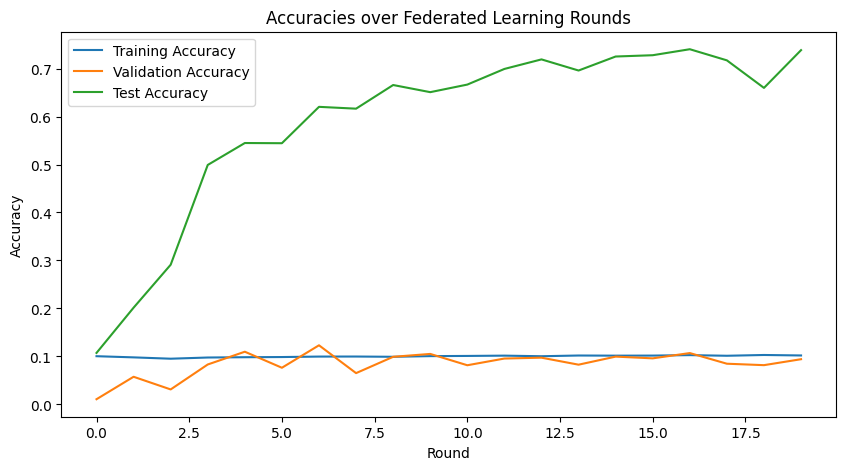

In [19]:
import matplotlib.pyplot as plt

# Plotting training, validation, and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracies over Federated Learning Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


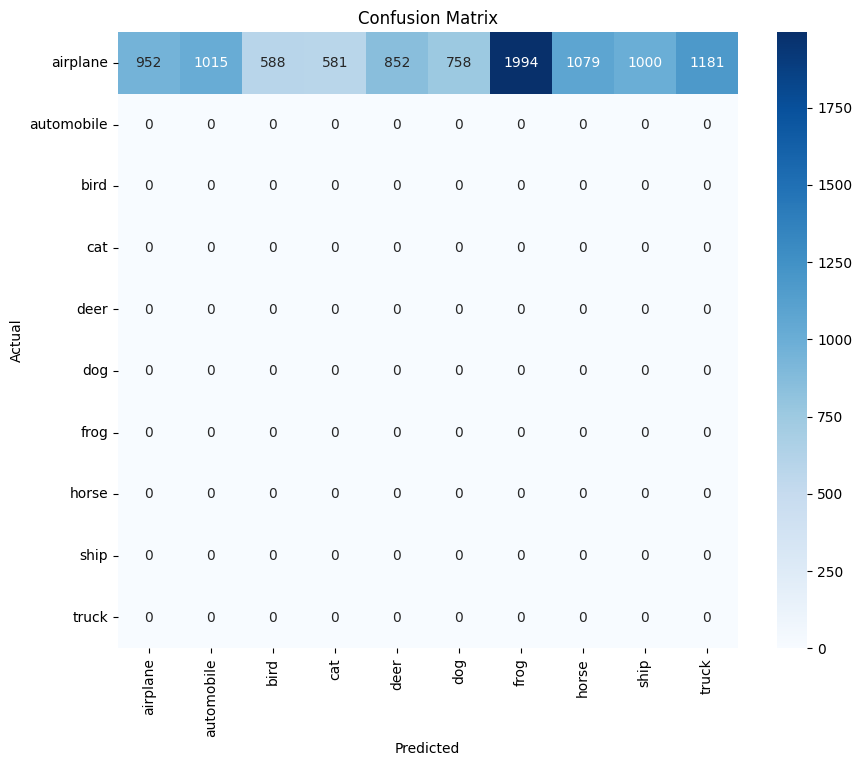

In [21]:
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the test dataset using the global model
predictions = np.argmax(global_model.predict(test_images), axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a heatmap for the confusion matrix with class names
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


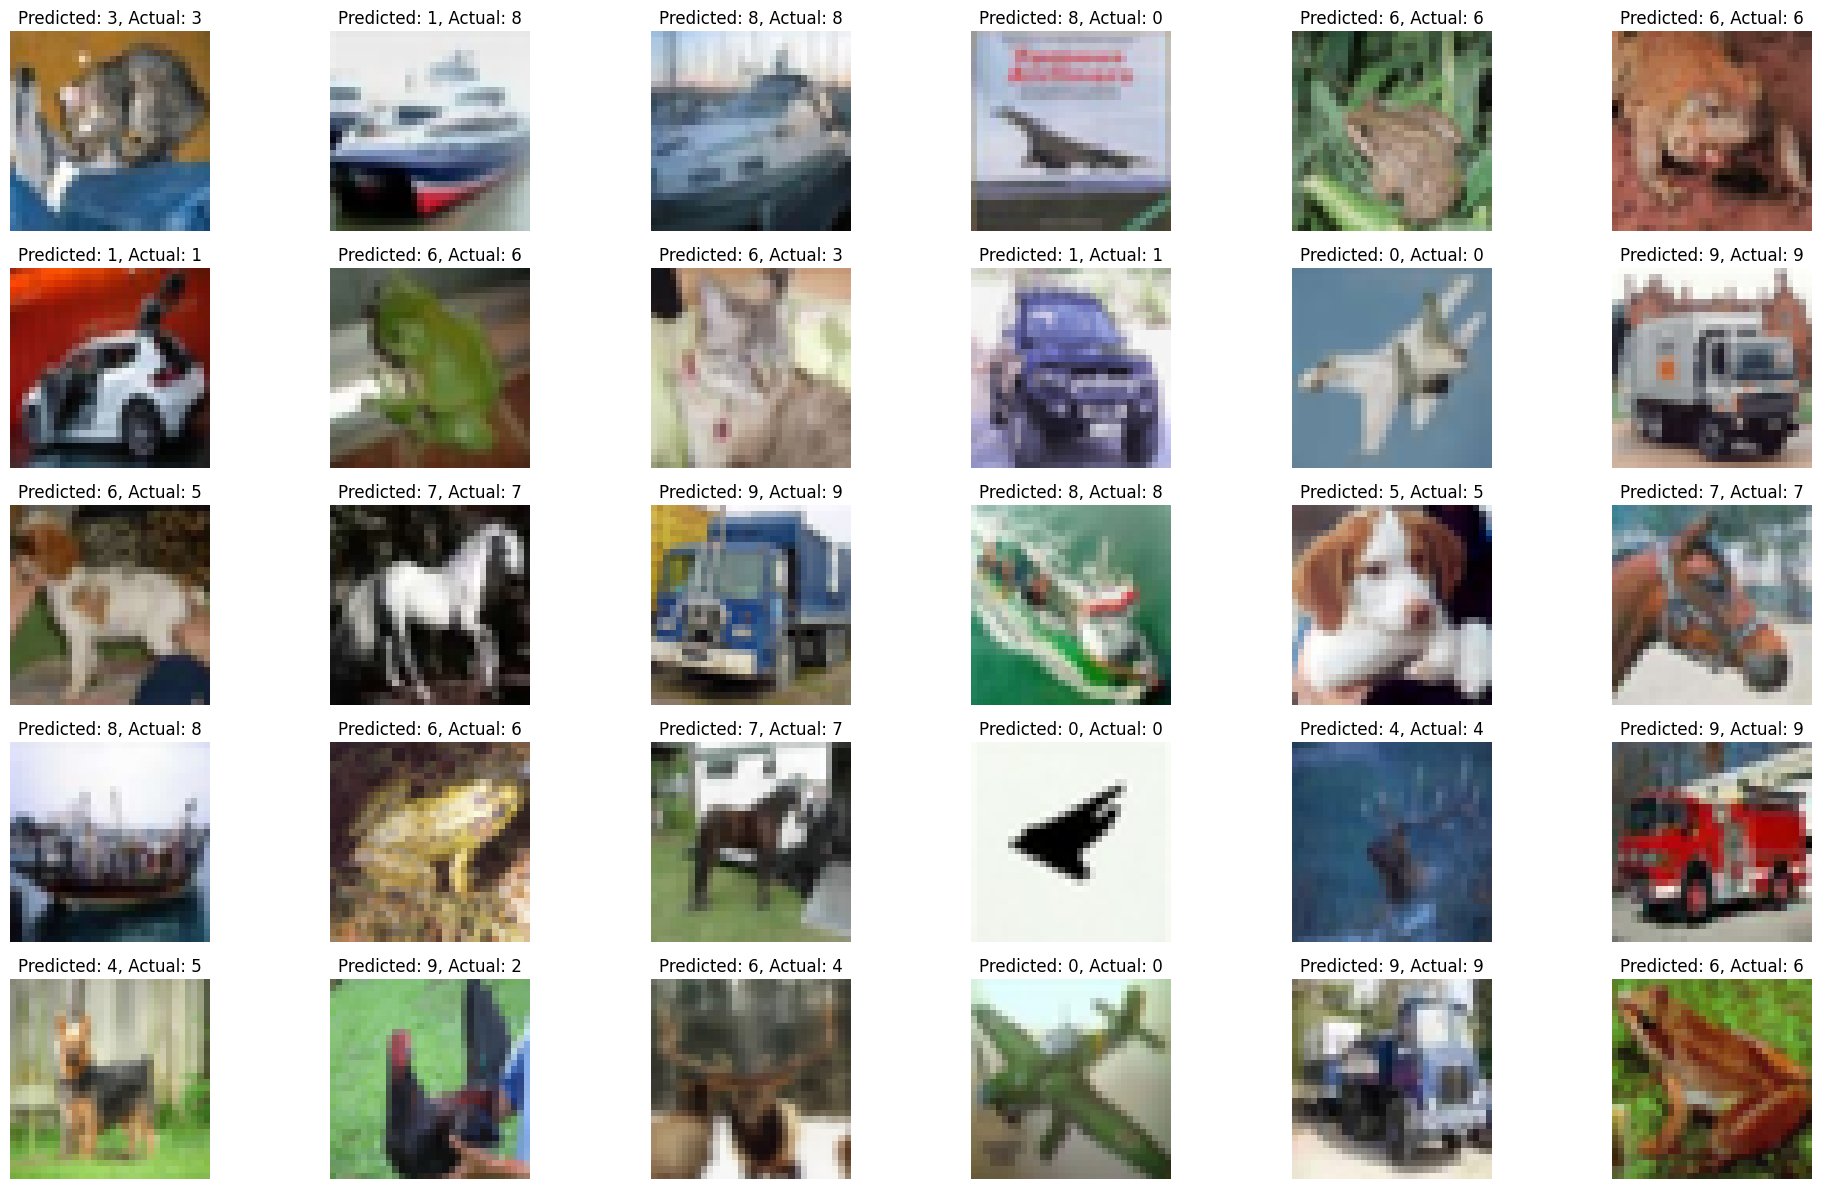

In [29]:
plt.figure(figsize=(20, 12))  # Increased size for better visibility
for i in range(30):
    plt.subplot(5, 6, i + 1)  # Adjusted for 3 rows and 10 columns
    plt.imshow(test_images[i])
    plt.title(f'Predicted: {predictions[i]}, Actual: {np.argmax(test_labels[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [23]:
__from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
global_model.save('/content/drive/MyDrive/Colab Notebooks/trained_model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/trained_model_2.h5')  # Replace with the actual path to your model file

# Load the CIFAR-10 test dataset
(_, _), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
test_images = test_images.astype('float32') / 255.0

# Ensure that the test labels are in the correct format
test_labels = test_labels.squeeze()  # Remove unnecessary dimensions if present

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_images, test_labels, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 [==============================] - 2s 4ms/step - loss: 0.7737 - accuracy: 0.7384
Test Loss: 0.773659884929657
Test Accuracy: 0.7383999824523926
